### Tutorial in hamiltorch for log probabilities

* For the corresponding blog post please see: https://adamcobb.github.io/journal/hamiltorch.html
* Bayesian neural networks are left to a different notebook 

In [21]:
%load_ext autoreload
%autoreload 2

import torch
import hamiltorch
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# mean = torch.tensor([0.,0.,0.,0.,0.])
# stddev = torch.tensor([5,1.,2.,3.,4.])

# mean = torch.zeros(10)
# stddev = 5*torch.ones(10)

mean = torch.tensor([0.,0.,0.])
stddev = torch.tensor([0.5,1.,2.]) 

## Sampling a multivariate Gaussian

In `hamiltorch`, we have designed the samplers to receive a function handle `log_prob_func`, which the sampler will use to evaluate the log probability of each sample. A `log_prob_func` must take a 1-d vector of length equal to the number of parameters that are being sampled. For the example of our multivariate Gaussian distribution, we can define our `log_prob_func` as follows:

In [4]:
def log_prob(omega):
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

## Sampling a truncated multivariate Gaussian

In [5]:
def log_prob(omega, c=None):
    normal_log = torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega)
    
    if c:
        sigmoid_log = torch.nn.functional.logsigmoid(c*(1-torch.norm(omega) ** 2))
        return (normal_log + sigmoid_log).sum()
    else:
        return normal_log.sum()


def getlogprobs(c):
    def f(omega):
        return log_prob(omega, c)
    return f

In [6]:
N = 200
step_size = 0.02
L = 100
burn = 0
c_sigmoid = 50

### Sample using standard HMC
* Initialise the parameters e.g. `params_init = torch.zeros(3)` and pass them into the `hamiltorch.sample()` function as `params_init=params_init`.
* Set the number of samples `num_samples=N` corresponding to the number of momentum resampling steps/the number of trajectories to sample.
* Set the step size and trajectory length via `step_size=step_size, num_steps_per_sample=L`.

In [7]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc = hamiltorch.sample(log_prob_func=getlogprobs(c=c_sigmoid), params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L, burn=burn)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:22 | 0d:00:00:00 | #################### | 200/200 | 9.03        
Acceptance Rate 0.98


In [8]:
coords_all_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1)
print((coords_all_hmc.shape))

torch.Size([19601, 3])


In [9]:
numSample = len(coords_all_hmc[:,1]) // L
index = L*torch.arange(numSample)
coords_hmc=coords_all_hmc[index]
coords_hmc=coords_hmc[burn:]

In [10]:
print(coords_hmc.shape)

torch.Size([196, 3])


In [11]:
# IID
targetDis = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)

In [12]:
# Generate accepted number of samples unnconstrained case

# coords_iid = targetDis.sample(coords_hmc[:,0].shape)
# print(coords_iid.shape)

In [13]:
coords_hmc = torch.round(coords_hmc*10 **3)/10 **3

In [14]:
# Generate accepted number of samples

sample_iid = targetDis.sample((8 * N,))
norm_iid = torch.norm(sample_iid, dim=-1) ** 2
ind_iid = torch.where(norm_iid <= 1)[0]
ind_iid = ind_iid[:len(coords_hmc[:,0])]
coords_iid = sample_iid[ind_iid]
print(coords_iid.shape)

torch.Size([196, 3])


In [15]:
coords_iid=torch.round(coords_iid*10 **3)/10 **3

In [16]:
# Generate full samples and reject

# sample_iid = targetDis.sample((N,))
# norm_iid = torch.norm(sample_iid, dim=-1) ** 2
# ind_iid = torch.where(norm_iid <= 1)[0]
# coords_iid = sample_iid[ind_iid]
# print(norm_iid.shape, ind_iid.shape)
# print(coords_iid.shape)
# print('IID acceptance rate     ', len(ind_iid)/len(norm_iid))

In [17]:
print('True mean:            ',mean)
print('HMC mean:            ',coords_hmc.mean(0))
print('IID mean:            ',coords_iid.mean(0))

True mean:             tensor([0., 0., 0.])
HMC mean:             tensor([-0.0002, -0.0007,  0.0153])
IID mean:             tensor([ 0.0340, -0.0389,  0.0072])


In [18]:
print('HMC mean norm:            ',torch.dot(coords_hmc.mean(0),coords_hmc.mean(0)))
print('IID mean norm:            ',torch.dot(coords_iid.mean(0),coords_iid.mean(0)))

HMC mean norm:             tensor(0.0002)
IID mean norm:             tensor(0.0027)


## Convert tensors to numpy for plotting

In [19]:
coords_hmc = coords_hmc.numpy()

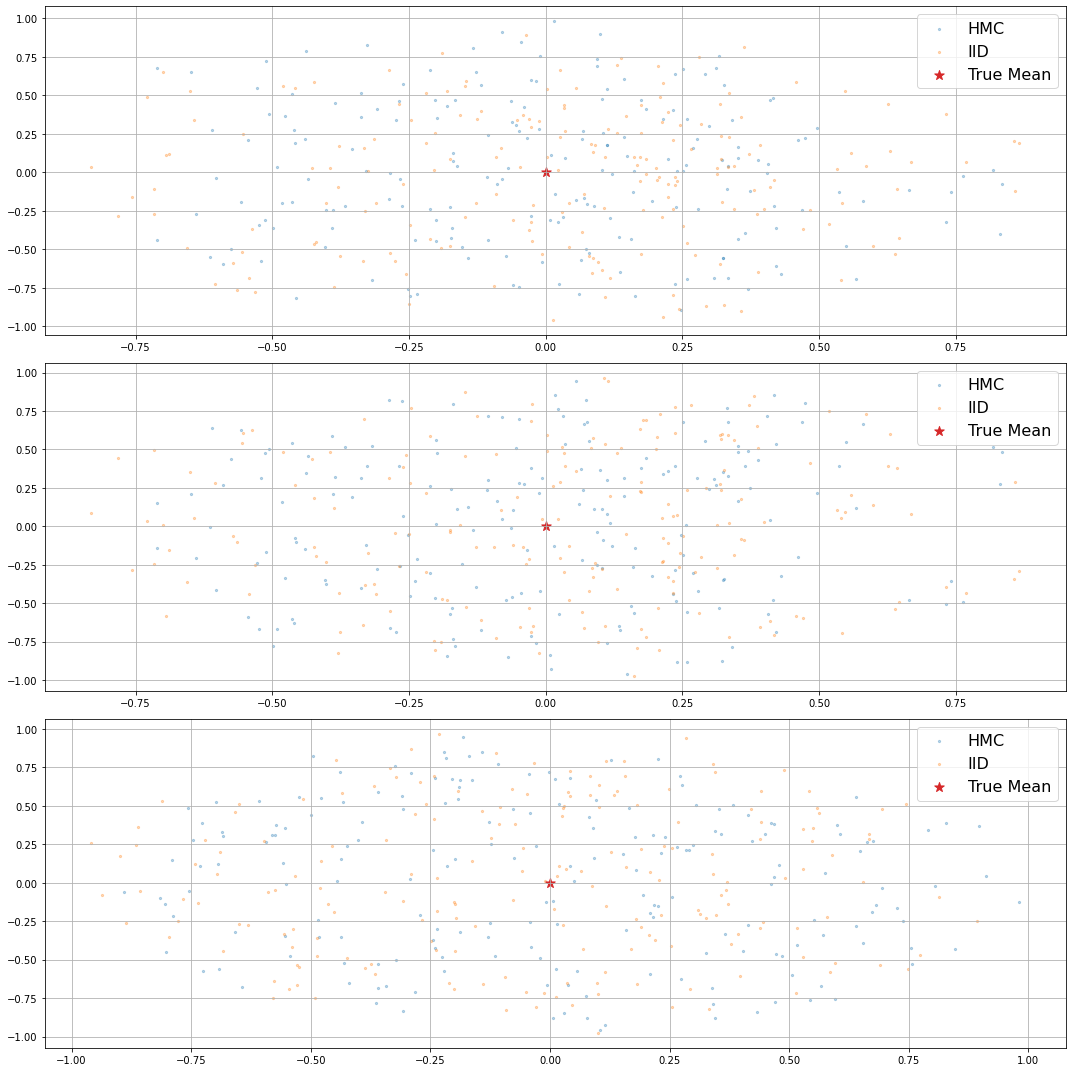

In [20]:
# xlim = [-5,5]
# ylim = [-5,5]
fs=16

fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].scatter(coords_hmc[:,0], coords_hmc[:,1],s=5,alpha=0.3,label='HMC')
axs[0].scatter(coords_iid[:,0], coords_iid[:,1],s=5,alpha=0.3,label='IID')
axs[0].scatter(mean[0],mean[1],marker = '*',color='C3',s=100,label='True Mean')
axs[0].legend(fontsize=fs)
axs[0].grid()
# axs[0].set_xlim(xlim)
# axs[0].set_ylim(ylim)

axs[1].scatter(coords_hmc[:,0], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[1].scatter(coords_iid[:,0], coords_iid[:,2],s=5,alpha=0.3,label='IID')
axs[1].scatter(mean[0],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[1].legend(fontsize=fs)
axs[1].grid()
# axs[1].set_xlim(xlim)
# axs[1].set_ylim(ylim)

axs[2].scatter(coords_hmc[:,1], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[2].scatter(coords_iid[:,1], coords_iid[:,2],s=5,alpha=0.3,label='IID')
axs[2].scatter(mean[1],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[2].legend(fontsize=fs)
axs[2].grid()
# axs[2].set_xlim(xlim)
# axs[2].set_ylim(ylim)

plt.tight_layout()

# plt.savefig('../../Gaussian_plots.png',bbox_inches='tight')
plt.show()